In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt

db_name = "../data/GeSiNW_fully_autonomous_tuning.db" # Database name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)


plt.style.use('default')
import sys
sys.path.append('../')

In [2]:
with open('../data/metadata_entropy_score_demo.pkl', 'rb') as f:
    meta_data = pickle.load(f)
meta_data

[EvaluationResult(score=-4.628174690540611, config={'freq_vs': 2750000000.0, 'burst_time_ns': 9.0, 'tangent_param_0': 0.0, 'norm_param': 0.0}, metadata={'guid': 'a9542251-0000-0000-0000-018a8108dfb2'}),
 EvaluationResult(score=-3.920388807058277, config={'freq_vs': 2825000000.0, 'burst_time_ns': 5.5, 'tangent_param_0': -0.004976583480834961, 'norm_param': 0.001845307159423828}, metadata={'guid': '4150adf3-0000-0000-0000-018a810e3eff'}),
 EvaluationResult(score=-4.6809209787101835, config={'freq_vs': 2675000000.0, 'burst_time_ns': 12.5, 'tangent_param_0': 0.00497658348083496, 'norm_param': -0.0018453071594238281}, metadata={'guid': 'cf16d557-0000-0000-0000-018a8113963d'}),
 EvaluationResult(score=-3.947573117222956, config={'freq_vs': 2787500000.0, 'burst_time_ns': 3.75, 'tangent_param_0': -0.002488291740417481, 'norm_param': -0.0009226535797119142}, metadata={'guid': '28d250a9-0000-0000-0000-018a8118f176'}),
 EvaluationResult(score=-4.585276912242178, config={'freq_vs': 2637500000.0, '

In [3]:
# local_ids = []
# for i in range(len(data)):
#     guid = data[i].metadata['guid']
#     ds = load_by_guid(guid)
#     local_ids.append(ds.run_id)
#
# from qcodes.dataset import (
#     Measurement,
#     connect,
#     extract_runs_into_db,
#     load_experiment_by_name,
#     load_or_create_experiment,
# )
# source_conn = connect(db_name)
# target_path = "../data/GeSiNW_fully_autonomous_tuning.db"
# target_conn = connect(target_path)
# for _id in local_ids:
#     extract_runs_into_db(db_name, target_path, _id)

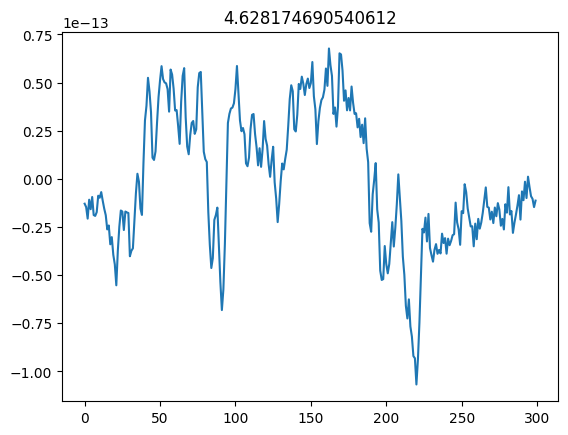

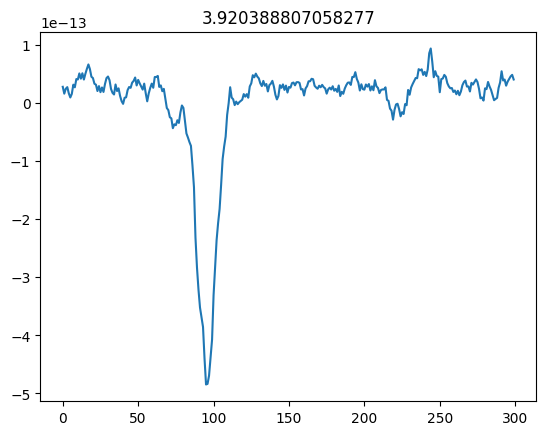

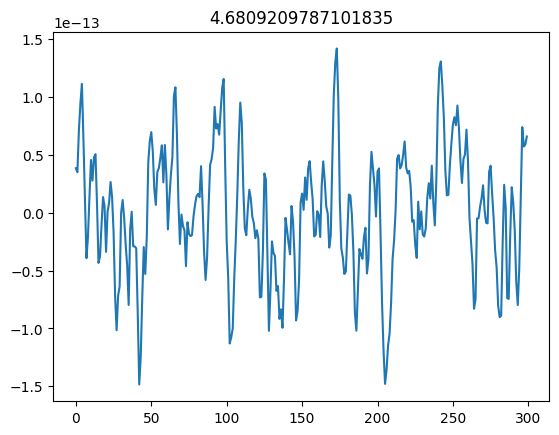

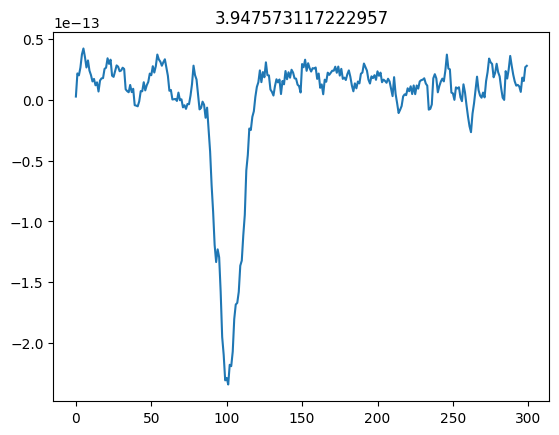

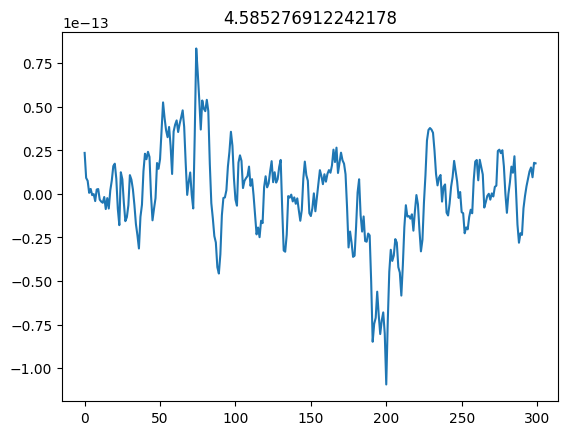

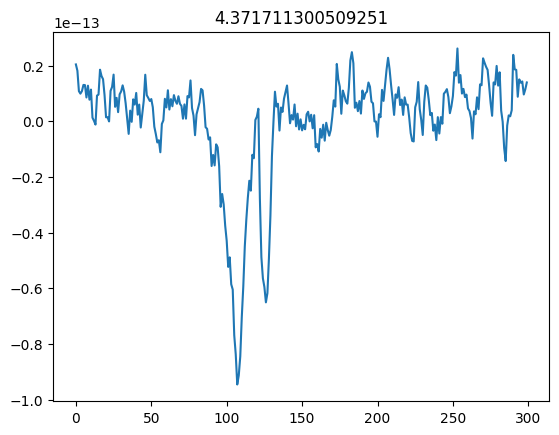

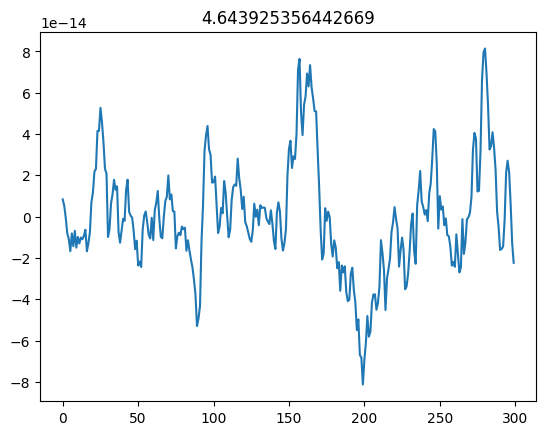

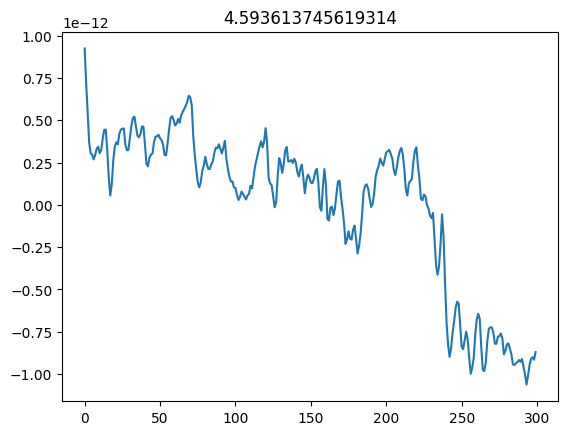

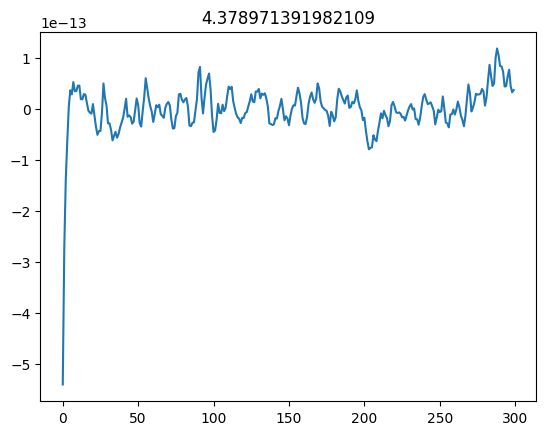

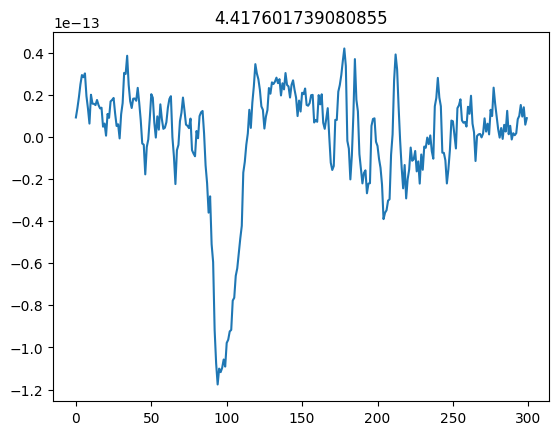

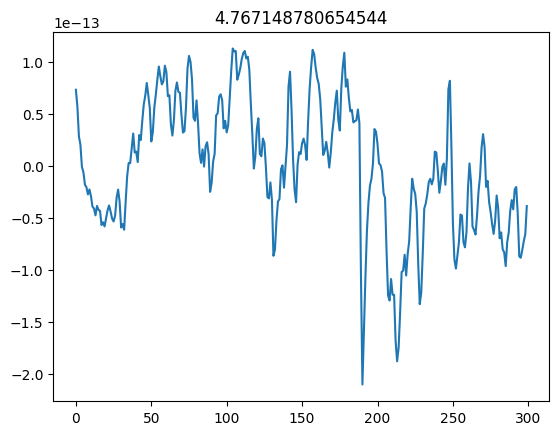

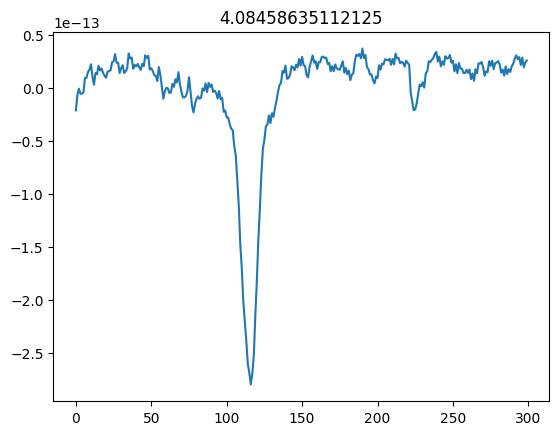

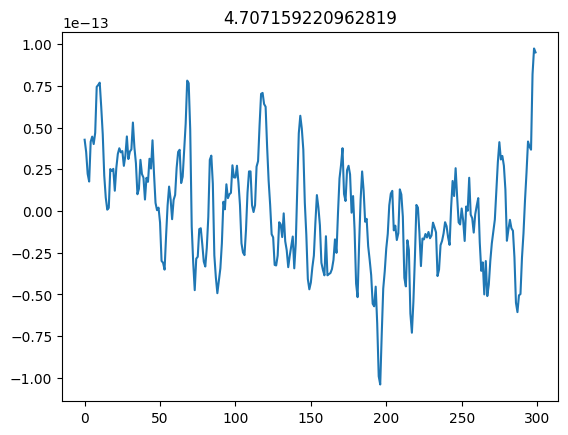

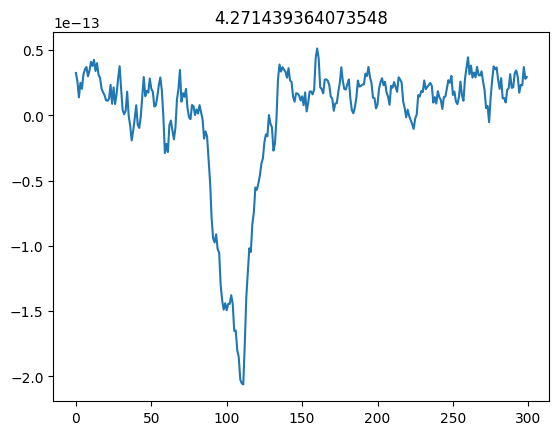

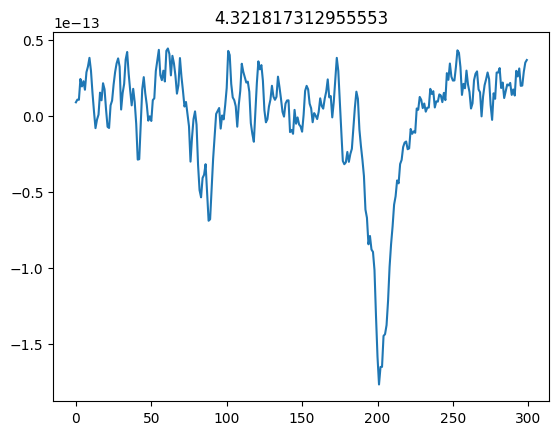

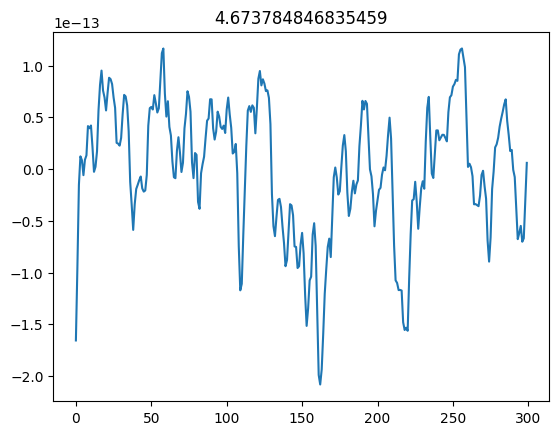

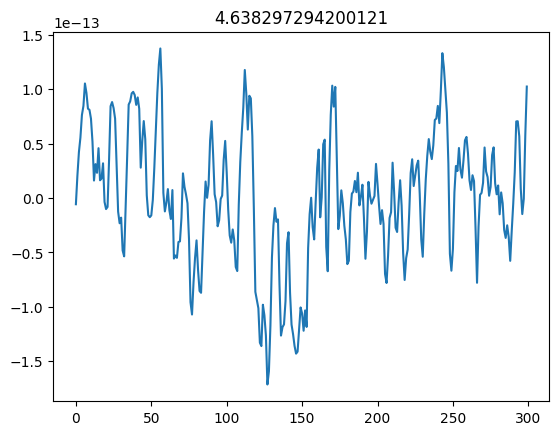

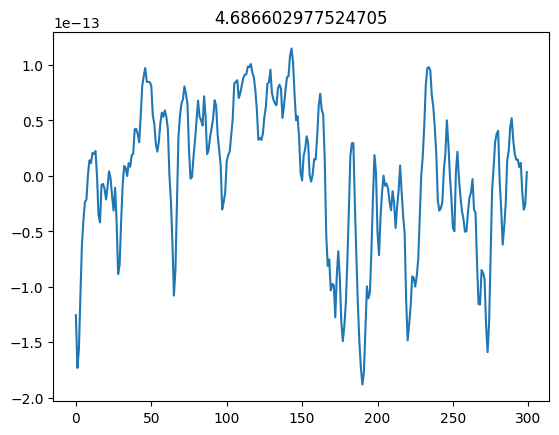

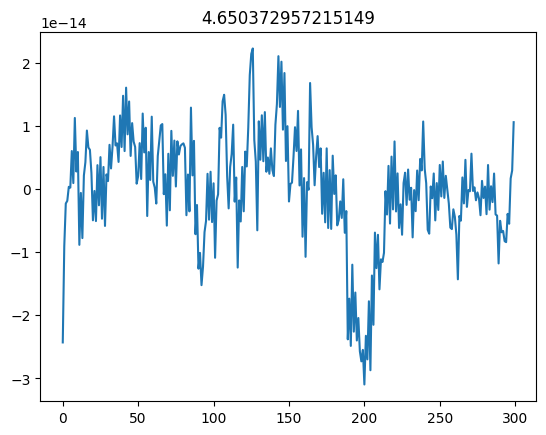

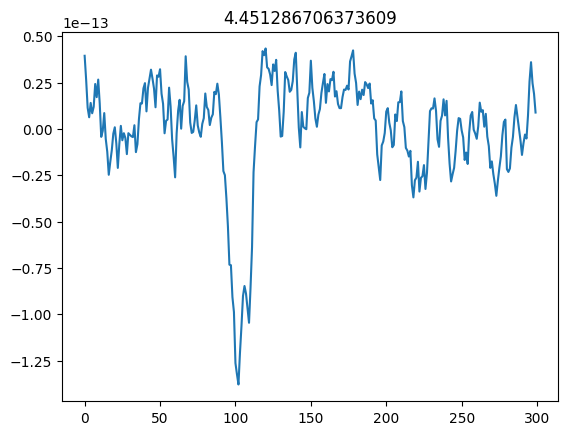

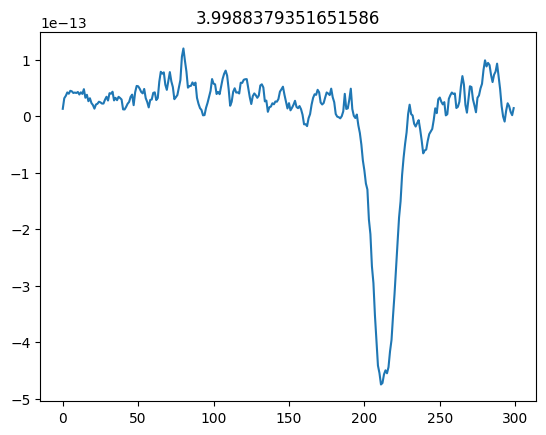

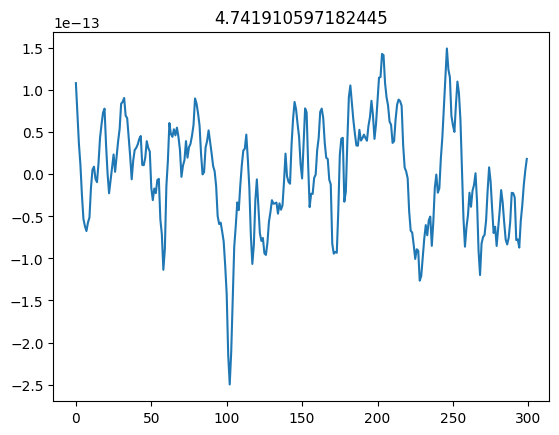

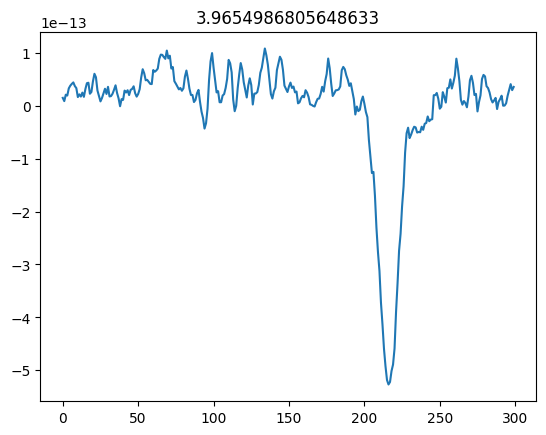

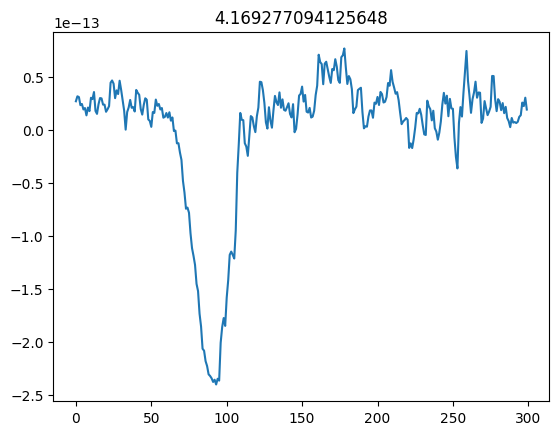

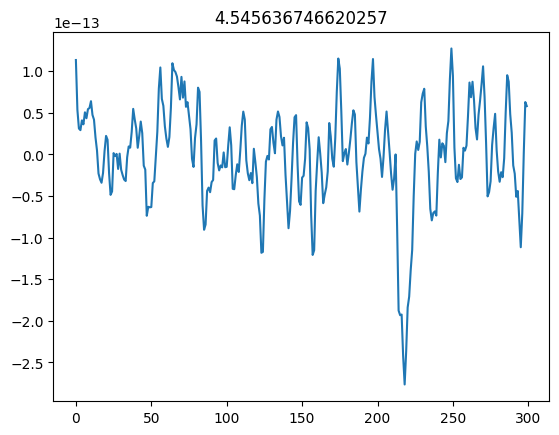

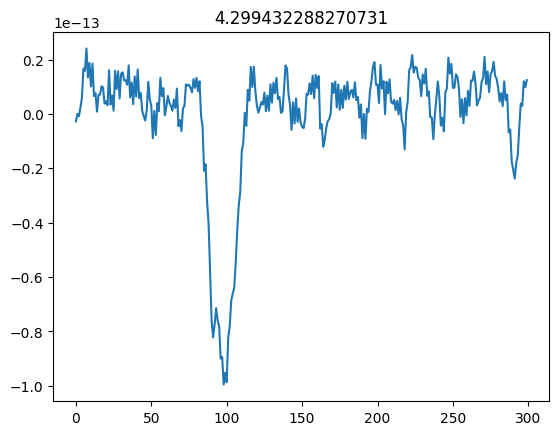

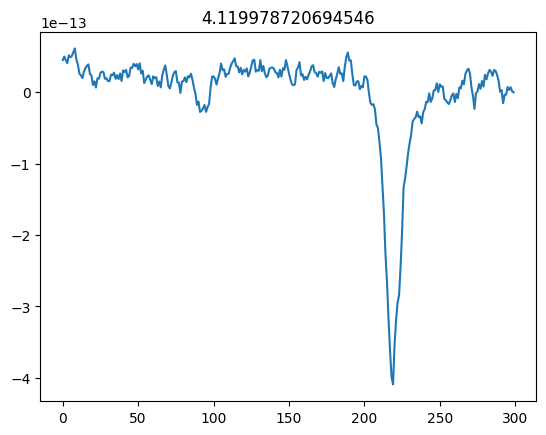

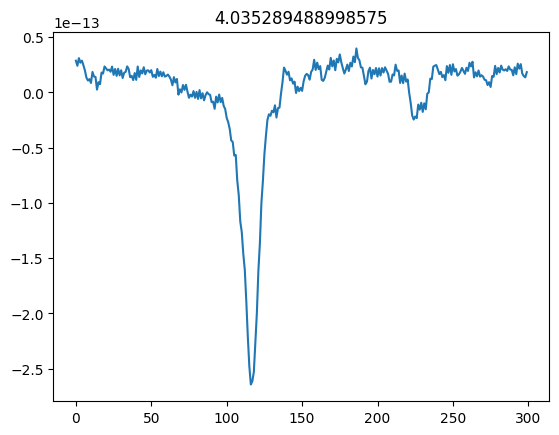

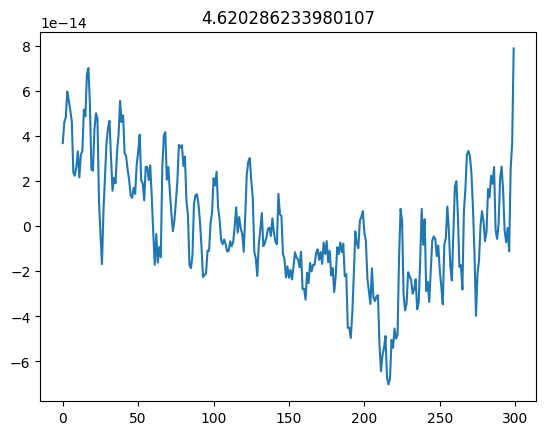

In [4]:
from data_visualisation.utils import PCA
from bias_triangle_detection.scores import EntropyScore

scorer = EntropyScore()

gathered_traces = []
gathered_scores = []
line_scan_xarrays = []

for i in range(len(meta_data)-1):
    guid = meta_data[i].metadata['guid']
    ds = load_by_guid(guid)
    lix = ds.to_xarray_dataset()['LIX']
    liy = ds.to_xarray_dataset()['LIY']
    pca = PCA(lix, liy)
    score = scorer(np.array([lix,liy]).swapaxes(0,1))

    plt.title(score)
    plt.plot(pca)
    plt.show()

    gathered_scores.append(score)
    gathered_traces.append([lix,liy])
    line_scan_xarrays.append(ds.to_xarray_dataset())

In [5]:

def plot_lockin_line_qcodes_all(
    line_scan_xarrays,
    scores,
    name_x="LIX",
    name_y="LIY",
    y_ticks = (0, 400)
):
    fig, axs_main = plt.subplots(5, 6, figsize=(12, 12))

    for i, (line_scan_xarray, score) in enumerate(zip(line_scan_xarrays, scores)):
        # print(line_scan_xarray, score)
        ax_main = plt.subplot(5,6, i+1)
        line_scant_x = line_scan_xarray[name_x].to_numpy().copy()
        line_scan_y = line_scan_xarray[name_y].to_numpy().copy()

        line_scan_accessed = PCA(line_scant_x, line_scan_y)

        axes_values = []
        axes_values_names = []
        axes_units = []
        for item, n in dict(line_scan_xarray.dims).items():
            axes_values.append(line_scan_xarray[item].to_numpy())
            axes_values_names.append(line_scan_xarray[item].long_name)
            axes_units.append(line_scan_xarray[item].unit)


        # fig, ax_main = plt.subplots(1, figsize=(10., 5))
        line_scan_accessed = line_scan_accessed - np.min(line_scan_accessed)
        plt.plot(axes_values[0], line_scan_accessed*1e15, color='white', linewidth=0.5)
        # axs[0].set_ylabel(axes_values_names[0] + ' [' + axes_units[0] + ']')
        plt.xlabel("B (T)")
        plt.ylabel("ISD (fA)")

        # plt.title("EDSR scan")
        plt.grid(False)
        plt.xticks([0, 0.4])
        plt.yticks(y_ticks)
        ax_main.set_title(f'Score={np.round(score, 3)}')
        ax_main.tick_params(direction='in',)
    plt.tight_layout()
    return fig

In [6]:
scores_sorted = np.sort(gathered_scores)
sorted_idx = np.argsort(gathered_scores)
line_scan_xarrays_sorted = []

for idx in sorted_idx:
    line_scan_xarrays_sorted.append(line_scan_xarrays[idx])


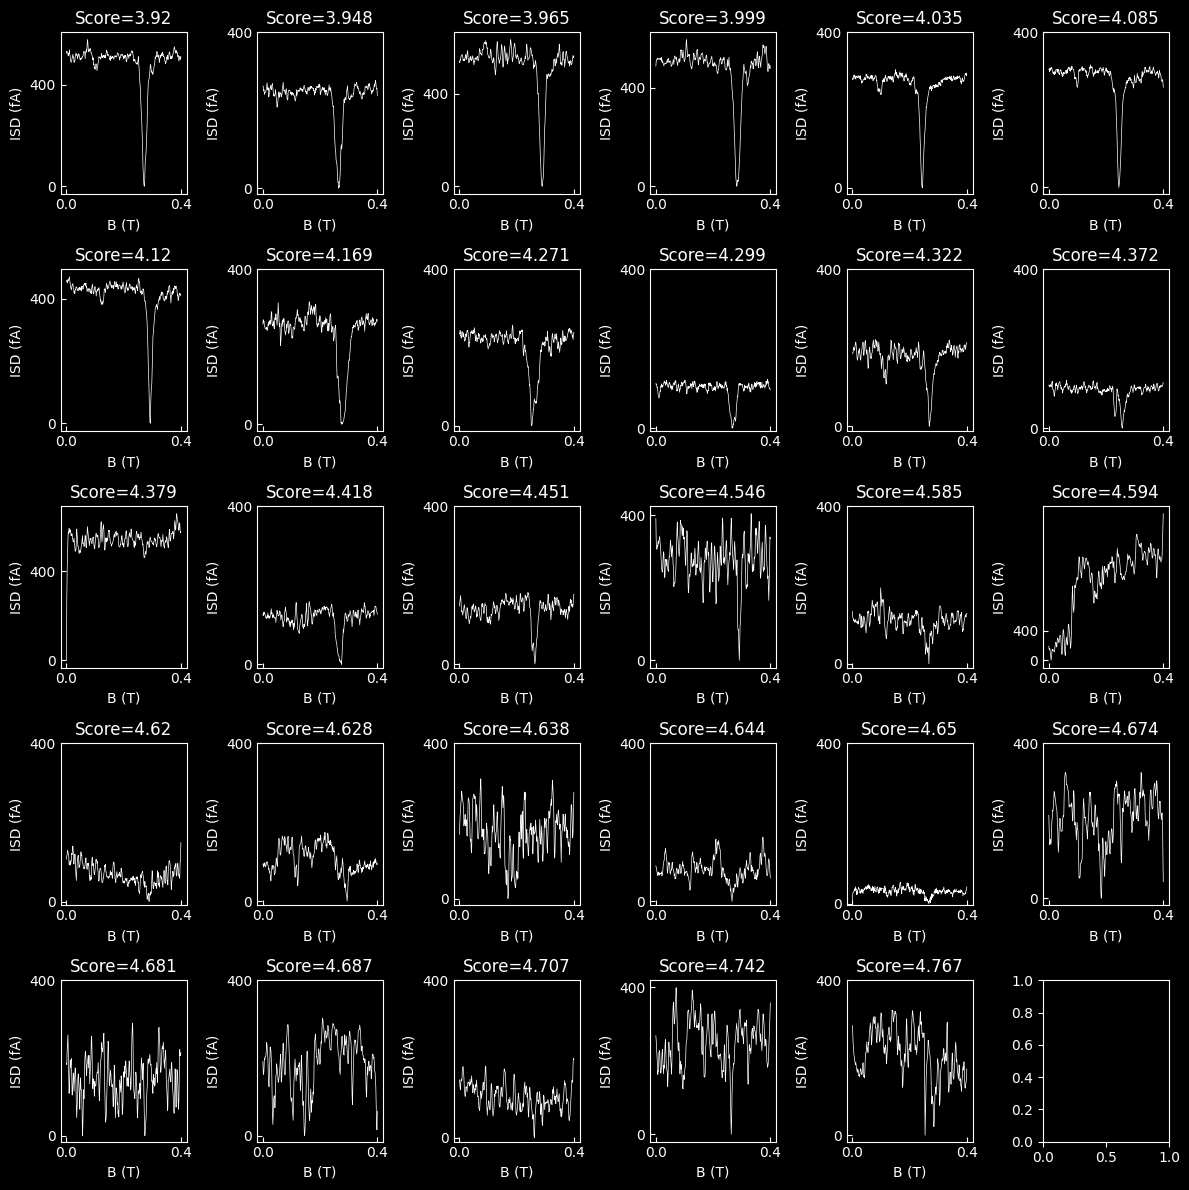

In [7]:
plt.style.use('dark_background')
fig = plot_lockin_line_qcodes_all(line_scan_xarrays_sorted, scores_sorted)
plt.show()